[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ibrahim85/Genetic-Alg-and-SARIMA/blob/master/Genetic%20Alg%20and%20SARIMA/Final_code.ipynb)

In [1]:
import os
os.cpu_count()

4

In [2]:
from IPython.display import clear_output 
for kk in range(0,35,5):
    for i in range(0,5): 
        clear_output() 
        print(i+kk)

34


In [3]:
file_name2    = 'score_table_SARIMAX2.csv'
file_name     = 'score_table_SARIMAX.csv'
file_network  = 'network_table_SARIMAX.csv'

In [4]:
import pandas as pd
from IPython.display import clear_output 
import time
from datetime import timedelta

#score_table
generations  = [10, 20, 50, 100, 200]  # Number of times to evole the population.
populations  = [10, 50, 100, 200, 300, 400, 500]  # Number of networks in each generation.

score_table = pd.DataFrame(index=range(0,175),columns= ['generations', 'population', '(p,d,q)', '(P,D,Q)','AIC','Time'])

k=0
for i in generations: 
    for j in populations:
        #print(i,j)
        l=k+4
        score_table.loc[k:l,:2] = (i, j)
        k=k+5

#score_table.set_index(['generations', 'population'])    
#score_table
def return_pos(gen,pop):
     return score_table.index[(score_table['generations'] == gen) & (score_table['population'] == pop)][0]
    

# 1- Parallel code¶

In [5]:
"""Entry point to evolving the neural network. Start here."""
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

from __future__ import print_function
import logging
from optimizer import Optimizer
from tqdm import tqdm
import sys

# Setup logging.
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO#,
    #filename='log.txt'
)

def train_networks(networks, dataset, type_ser):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    pbar = tqdm(total=len(networks))
    for network in networks:
        network.train(dataset, type_ser)
        pbar.update(1)
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.

    Args:
        networks (list): List of networks

    Returns:
        float: The average accuracy of a population of networks.

    """
    total_accuracy = 0
    for network in networks:
        if network.accuracy != -1 and network.accuracy != None:
            total_accuracy += network.accuracy
        else:
            continue

    return total_accuracy / len(networks)

def get_min_mse(networks):
    """Get the average accuracy for a group of networks/genomes.

    Args:
        networks (list): List of networks/genomes

    Returns:
        float: The average accuracy of a population of networks/genomes.

    """
    min_accuracy = 1000000
    min_network  = None
    for network in networks:
        if network.accuracy != -1 and network.accuracy < min_accuracy:
            min_accuracy = network.accuracy
            min_network=network
        else:
            continue
    return min_accuracy,min_network

def generate(cfg, k, nn_param_choices, dataset, type_ser):
    start_time = time.time()
    generations, population = cfg
    """Generate a network with the genetic algorithm.

    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating

    """
    logging.info("***Evolving %d generations with population %d***" % (generations, population))
    logging.info("***generate(generations, population, nn_param_choices, dataset)***")
    optimizer = Optimizer(nn_param_choices)
    #print("--1--")
    networks = optimizer.create_population(population)
    #print("--2--")
    min_networks=[]
    # Evolve the generation.
    for i in range(generations):
        logging.info("*** Now in generation %d of %d ***" %(i + 1, generations))
        #print_networks(networks)
        # Train and get accuracy for networks.
        train_networks(networks, dataset, type_ser)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        min_mse,net =get_min_mse(networks)
        #print_networks(net)
        #net.print_network()
        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f" % (average_accuracy ))#* 100
        logging.info('-'*80) #-----------
        logging.info("Generation min_mse: %.2f" % (min_mse ))#* 100
        logging.info('-'*80) #-----------

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution.
            networks = optimizer.evolve(networks)
        min_networks.append(net)
        clear_output()
    # Sort our final population.
    # Sort our final population according to performance.
    networks=[x for x in networks if x.accuracy !=-1 and x.accuracy != None]
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=False)
    print("Generation done")

    # Print out the top 5 networks.
    logging.info("top 5 networks Generation" )
    logging.info('='*80) #-----------
    print_networks(networks[:5])
    
    elapsed_time_secs = time.time() - start_time
    #pd.DataFrame(networks[:5]).to_csv(file_network, sep=',', encoding='utf-8', mode='a', header=True)
    for n in range(0,5):
        pos=return_pos(generations, population)
        score_table.loc[pos+n,2:] = networks[n].param, networks[n].param_seasonal, networks[n].accuracy, elapsed_time_secs#timedelta(seconds=round(elapsed_time_secs))
        #score_table.loc[pos+n,0] = timedelta(seconds=round(elapsed_time_secs))
    score_table.to_csv(file_name, sep=',', encoding='utf-8', mode='a', header=True)
    
    logging.info("min networks Generation" )
    logging.info('-'*80) #-----------
    min_networks = sorted(min_networks, key=lambda x: x.accuracy, reverse=False)
    print_networks(min_networks)
    return networks
    
def print_networks(networks):
    """Print a list of networks.

    Args:
        networks (list): The population of networks

    """
    logging.info('#'*80)
    for network in networks:
        network.print_network()
        
# grid search configs
def grid_search(dataset, models_gen, nn_param_choices, type_ser, parallel=True):
	scores = None
	k=0
	if parallel:
    #print("$$$$$$$$$$$$$$$$$$$$ %s $$$$$$$$$$$$$$$$$"% (type_ser))
    #networks = generate(generation, population, k, nn_param_choices, dataset, type_ser)
    #k=k+5
		# execute configs in parallel cfg, k, nn_param_choices, dataset, type_ser
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		#tasks = (delayed(generate)(generation, population, k, nn_param_choices, dataset, type_ser) for cfg in cfg_list)
		networks = (delayed(generate)(cfg, k, nn_param_choices, dataset, type_ser) for cfg in models_gen)
		scores   = executor(networks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	#scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	#scores.sort(key=lambda tup: tup[1])
	return scores
    
def main():
    """Evolve a network."""
    generations  = [10, 20]  # Number of times to evole the population.[10, 20, 50, 100, 200]
    populations  = [ 10, 50]  # Number of networks in each generation. [10, 50, 100, 200, 300, 400, 500]
    dataset = 'cifar10'
   
    nn_param_choices = {
        'p_values' : range(0, 3),#range(0, 13)
        'd_values' : range(0, 2),#range(0, 2)
        'q_values' : range(0, 3),#range(0, 13)
        'sp_values': range(0, 3),#range(0, 13)
        'sd_values': range(0, 2),#range(0, 2)
        'sq_values': range(0, 3) #range(0, 13)
    }
    type_ser ='normalized'
    models_gen = list()
    #for type_ser in ['normal', 'log', 'loglog']: #'normalized',
    for generation in generations: #'normalized',
        for population in populations:
            cfg1 = [generation, population]
            models_gen.append(cfg1)
          
    networks = grid_search(dataset, models_gen, nn_param_choices, type_ser)       
    return networks

In [6]:
#if __name__ == '__main__':
networks = main()

Generation done


02/10/2020 09:38:45 PM - INFO - top 5 networks Generation
02/10/2020 09:38:45 PM - INFO - ================================================================================
02/10/2020 09:38:45 PM - INFO - ################################################################################
02/10/2020 09:38:45 PM - INFO - {'p_values': 1, 'd_values': 0, 'q_values': 0, 'sp_values': 1, 'sd_values': 0, 'sq_values': 1}
02/10/2020 09:38:45 PM - INFO - Network accuracy: -159.50%
02/10/2020 09:38:45 PM - INFO - {'p_values': 1, 'd_values': 0, 'q_values': 0, 'sp_values': 1, 'sd_values': 0, 'sq_values': 1}
02/10/2020 09:38:45 PM - INFO - Network accuracy: -159.50%
02/10/2020 09:38:45 PM - INFO - {'p_values': 1, 'd_values': 0, 'q_values': 0, 'sp_values': 1, 'sd_values': 0, 'sq_values': 1}
02/10/2020 09:38:45 PM - INFO - Network accuracy: -159.50%
02/10/2020 09:38:45 PM - INFO - {'p_values': 1, 'd_values': 0, 'q_values': 0, 'sp_values': 1, 'sd_values': 0, 'sq_values': 1}
02/10/2020 09:38:45 PM - INFO - Net

# save results to file

In [7]:
score_table.to_csv(file_name2, sep=',', encoding='utf-8', mode='a', header=True)

# plot parallel time for GA-SARIMA

In [29]:
import time
import warnings
import itertools
import numpy as np
import pandas as pd
from math import sqrt
from joblib import Parallel
from joblib import delayed
from pandas import read_csv
from pandas import datetime
from datetime import timedelta
from pandas import DataFrame
import statsmodels.api as sm
from matplotlib import pyplot
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


plt.style.use('fivethirtyeight')
print ("libraries loaded")

libraries loaded


In [12]:


# Get the data.
filename='time2.csv'
#filename='india_all_stations_comma.txt'
series5 = read_csv( filename,  header=0, index_col=0 )
series5=series5.dropna(axis=0)
#series = series.iloc[:1000,]  # independent variables
print(series5.head(7))
#series.describe()
series4=pd.DataFrame(columns=['generations','population' ,'Time'])
series4[['generations','population' ,'Time']]=series5[['generations','population' , 'Time']]
series4=series4.reset_index(drop=True)
#series5[['AIC']][series5['generations']==100]
#series4[['population']][series4['generations']==100]

       generations  population   (p  d   q)  (P  D  Q    s)         AIC  \
index                                                                     
0               10          10   (0  1   8)  (2  0  2   12) -149.524552   
5               10          50   (1  0   2)  (2  0  2   12) -154.041926   
10              10         100   (0  0   3)  (2  0  2   12) -156.908104   
15              10         200   (1  0   0)  (2  0  2   12) -157.864563   
20              10         300   (1  0   0)  (1  0  1   12) -159.496669   
25              10         400   (1  0   0)  (1  0  1   12) -159.496669   
30              10         500  (11  1   1)  (0  0  1   12) -158.326306   

                Time  
index                 
0        1192.058688  
5        9410.121537  
10      22615.712673  
15      39723.027160  
20      63318.764635  
25     108862.663369  
30     123527.194000  


In [13]:
z1=series5[['AIC']][series5['generations']==100]
for i in [10,20,50,100,200]:
    x1=series4[['population']][series4['generations']==i]
    y1=series4[['Time']][series4['generations']==i]
    z1=series5[['AIC']][series5['generations']==i]
    for label, x, y in zip(z1['AIC'], x1['population'], y1['Time']):
        label1 = "{:.2f}".format(label)
        #print(str(label1),x, y)
        #print('-------------')
#z1[-1:]

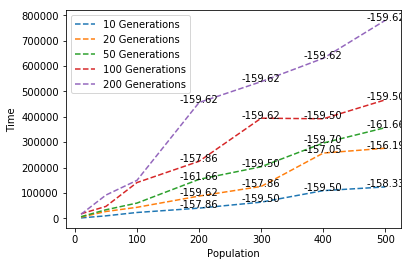

In [14]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
for i in [10,20,50,100,200]:
    x1=series4[['population']][series4['generations']==i]
    y1=series4[['Time']][series4['generations']==i]
    z1=series5[['AIC']][series5['generations']==i]
    plt.plot(x1,y1,'--',label=str(str(i)+' Generations'))

    for label, x, y in zip(z1['AIC'], x1['population'], y1['Time']):
        if x > 100:
            label1 = "{:.2f}".format(label)
            plt.annotate(label1, xy = (x , y ), xytext=(x+0.01 , y+100), fontsize = 10,rotation=0, ha='center',clip_on=True)
    
plt.legend(loc='upper left')
plt.xlabel('Population')
plt.ylabel('Time')
plt.savefig("time_parallel_plot1.png", dpi=600)
plt.show()


# plot time series

In [16]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
def norm_series(series):
    y = series.resample('MS').mean()
    values2 = y.values
    values2 = values2.reshape((len(values2), 1))
    # train the normalization
    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    scaler2 = scaler2.fit(values2)
    ser2 = DataFrame(y)
    ser2['normalized']= scaler2.transform(values2)
    ser2['log']=np.log(values2 )
    ser2['loglog']=np.log(np.log(values2 ))
    ser2.head(4)
    return ser2, scaler2

In [17]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Get the data.
filename='433440-99999-merge.csv'

#filename='india_all_stations_comma.txt'
series = read_csv( filename, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
series=series.dropna(axis=0)
#series = series.iloc[:1000,]  # independent variables
print(series.head())
series.describe()

YEARMODA
2000-01-01    76.0
2000-01-02    77.1
2000-01-03    76.0
2000-01-04    77.3
2000-01-05    76.9
Name: TEMP, dtype: float64


count    6201.000000
mean       84.337687
std         4.764565
min        69.000000
25%        80.200000
50%        85.000000
75%        88.300000
max        95.100000
Name: TEMP, dtype: float64

In [18]:
index_min, index_max = np.argmin(series), np.argmax(series)
index_min, index_max 

/home/gad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)
/home/gad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


(Timestamp('2016-12-01 00:00:00'), Timestamp('2003-05-20 00:00:00'))

/home/gad/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


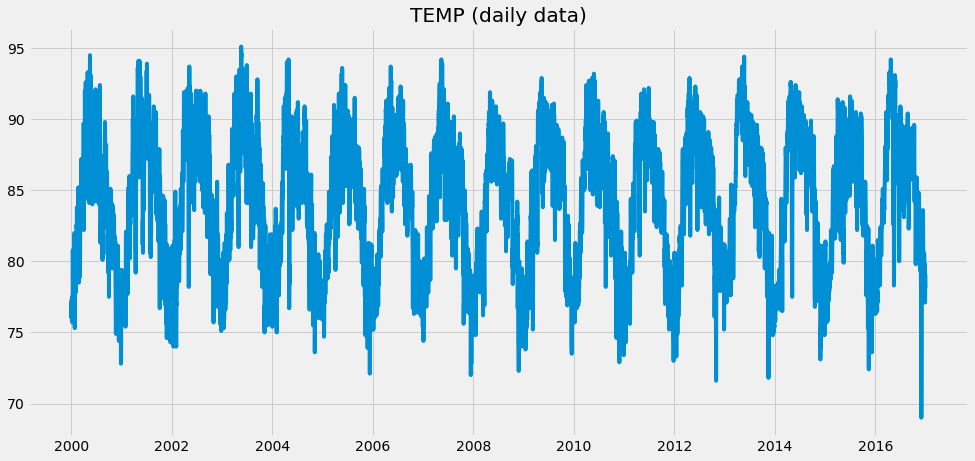

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(series)
plt.title('TEMP (daily data)')
plt.grid(True)
plt.show()

In [20]:
series2,scaler2 =norm_series(series)
series2.head(3)

,TEMP,normalized,log,loglog
YEARMODA,,,,
2000-01-01,77.866667,-0.885479,4.354998,1.471324
2000-02-01,81.332143,-0.418870,4.398541,1.481273
2000-03-01,84.851613,0.055009,4.440904,1.490858


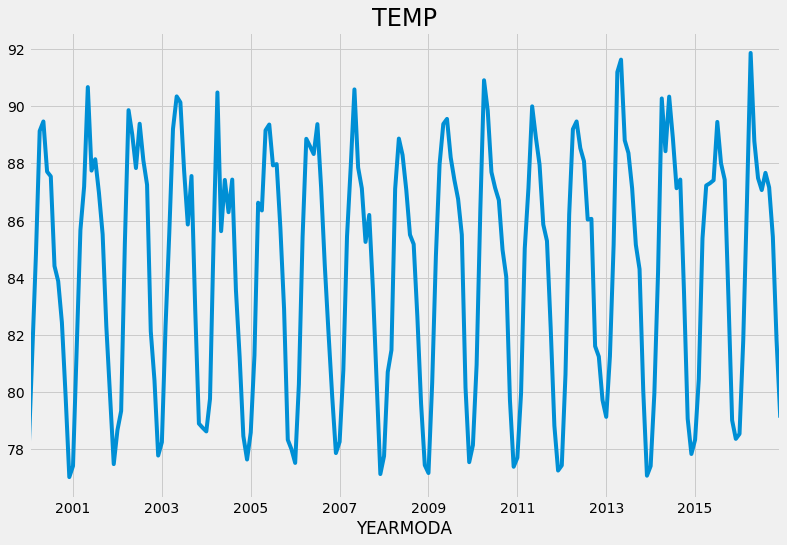

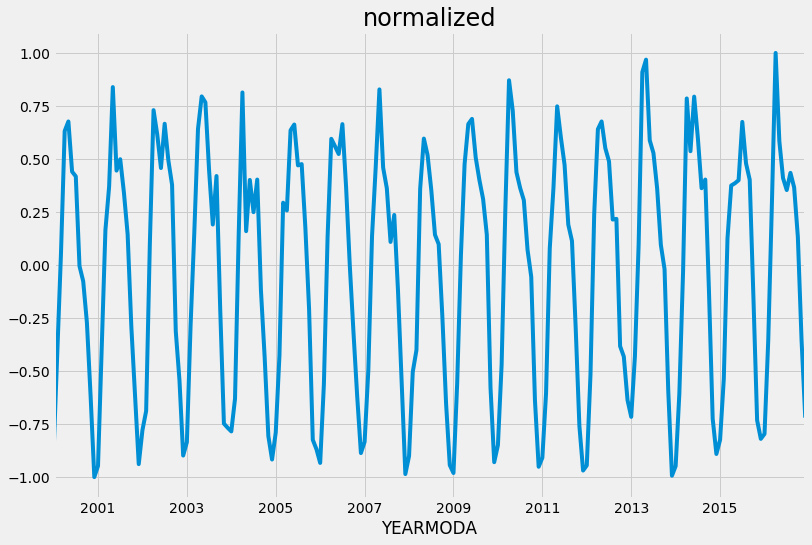

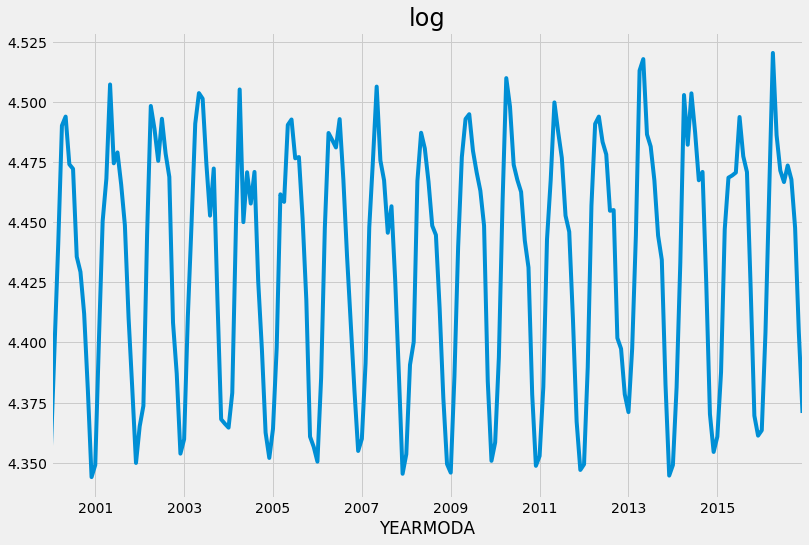

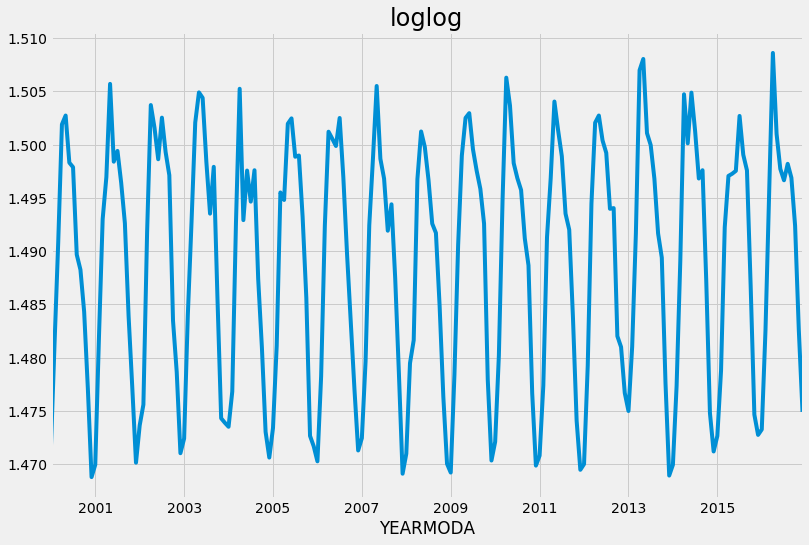

In [21]:
for i in ['TEMP' ,'normalized','log','loglog']:
    series2[i].plot(figsize=(12,8))
    plt.title(i,fontsize=24)
    pyplot.show()

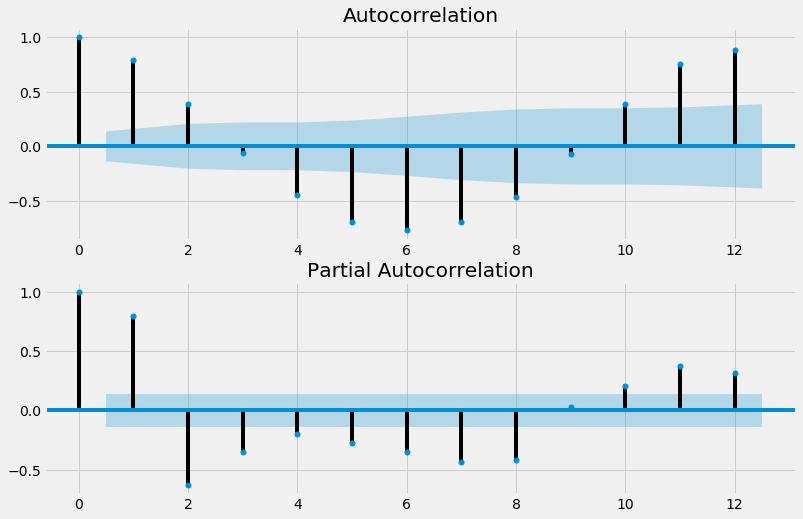

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series2['TEMP'].values.squeeze(), lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series2['TEMP'], lags=12, ax=ax2)

#series2.plot()
pyplot.show()

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:984: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


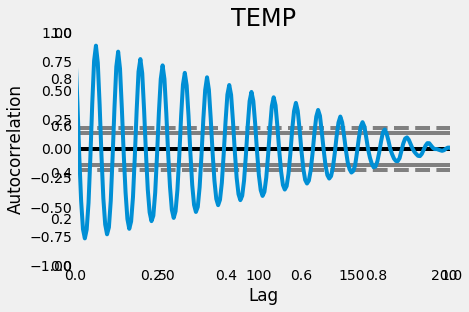

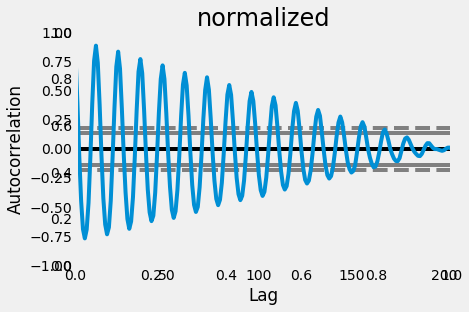

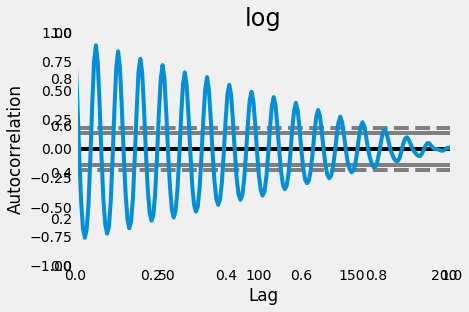

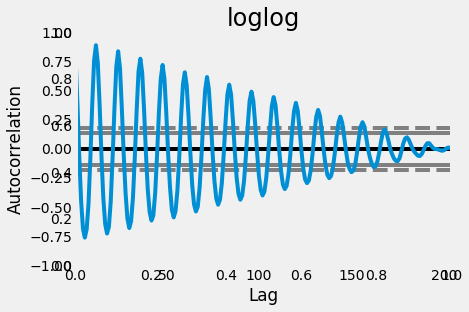

In [23]:
for i in ['TEMP' ,'normalized','log','loglog']:
    plt.title(i,fontsize=24)
    autocorrelation_plot(series2[i])
    pyplot.show()

## plot ACF PACF

In [24]:
# daily PM2.5 data for Beijing

fig = plt.figure(figsize=(18,15));
fig.suptitle('ACF and PACF plots for daily data');

ax1 = fig.add_subplot(221)
plot_acf(series, ax=ax1, color='blue');
ax1.set_xlabel('Lags (days)');

ax2 = fig.add_subplot(222)
plot_acf(series,lags=32, ax=ax2, title='Autocorrelation for lags of 32 days', color='blue');
ax2.set_xlabel('Lags (days)');

ax3 = fig.add_subplot(223)
plot_pacf(series, lags=400, ax=ax3, title='Partial Autocorrelation for lags of 365 days (1 year)', color='blue');
ax3.set_xlabel('Lags (days)');

ax4 = fig.add_subplot(224)
plot_pacf(series, lags=32, ax=ax4, title='Partial Autocorrelation for lags of 32 days', color='blue');
ax4.set_xlabel('Lags (days)');

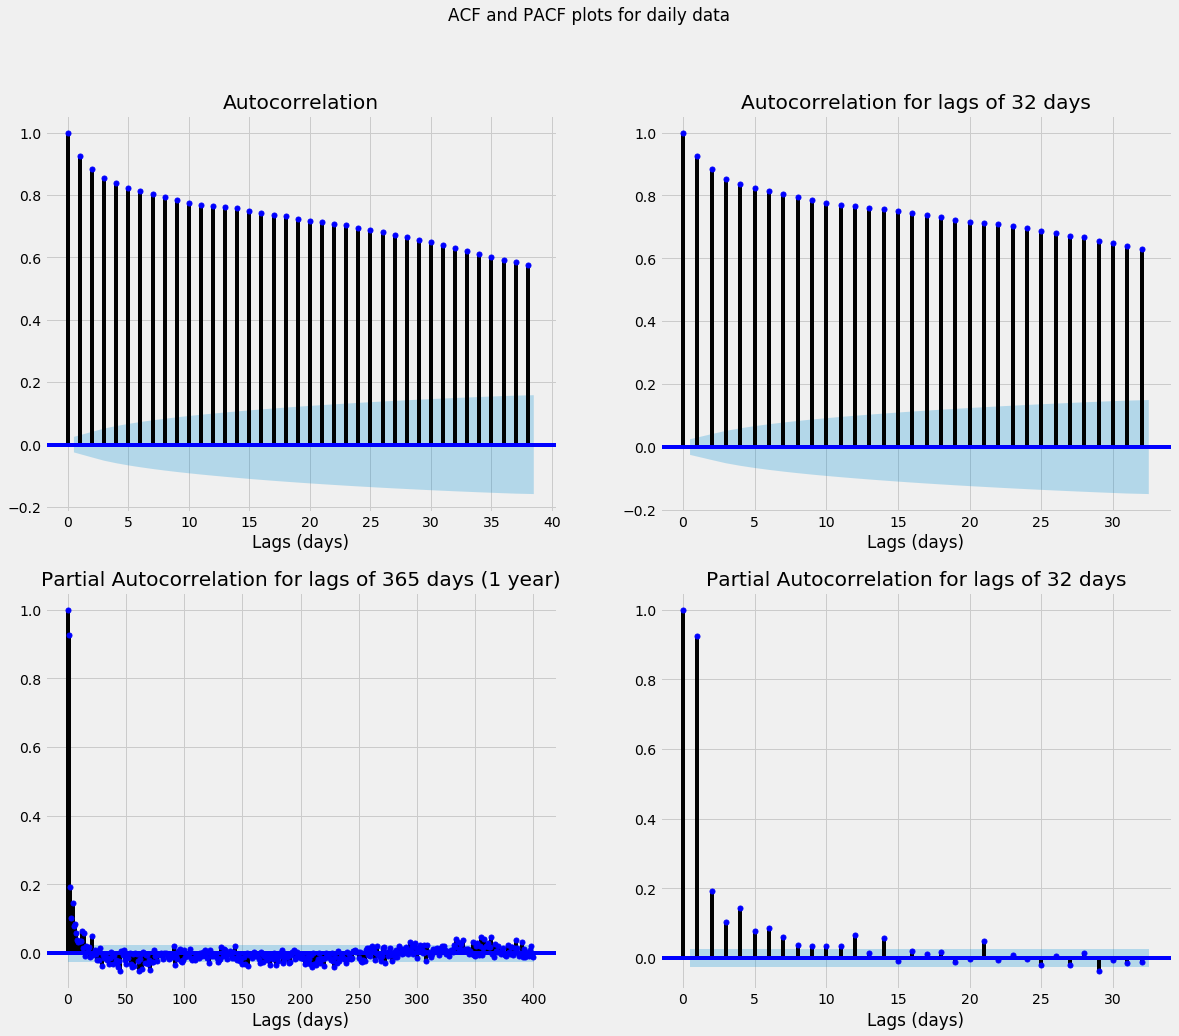

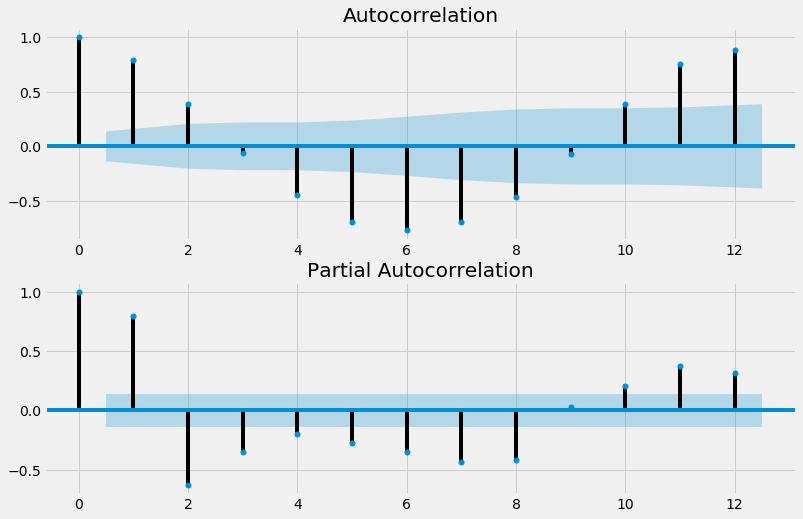

In [25]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
for i in ['normalized']:
    #plt.title(i,fontsize=24)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(series2[i], lags=12, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(series2[i], lags=12, ax=ax2)
    plt.show()

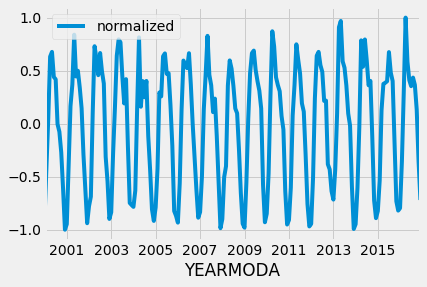

In [26]:
from pandas import DataFrame
from scipy import stats

residuals8 = DataFrame(series2['normalized'])
residuals8.plot(kind='line')
plt.show()

## Decomposition plots

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


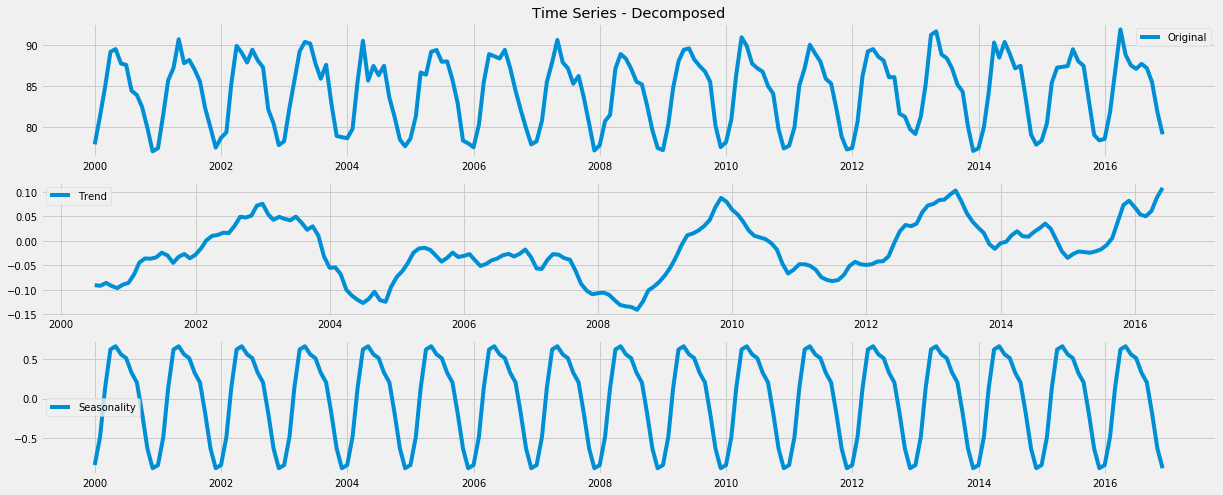

In [34]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
decomposition = seasonal_decompose(series2['normalized'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(17,9))
plt.subplot(411)
plt.title('Time Series - Decomposed')
plt.plot(series2['TEMP'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

/home/gad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  
/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


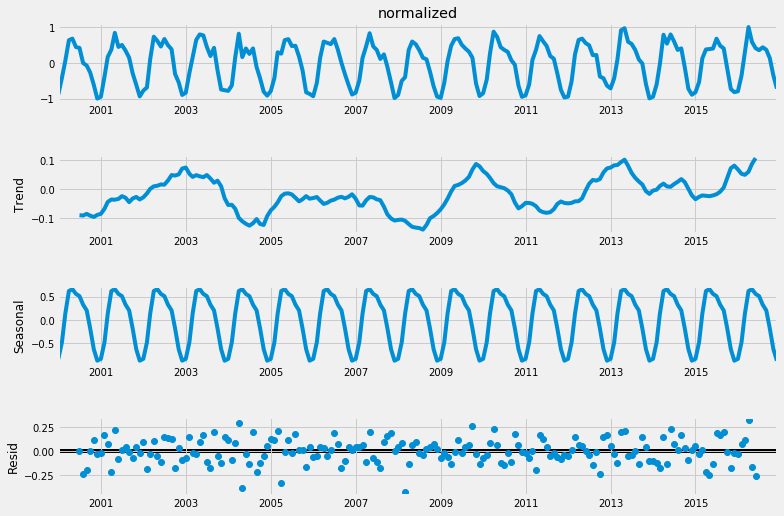

In [35]:
# decomposition
decomposition = seasonal_decompose(series2['normalized'], freq=12) # freq = 1 year
fig = decomposition.plot()
fig.set_size_inches(12, 8);
plt.show()

# Results diagnostics test 

In [40]:
# train test split for daily PM2.5 data
series_daily_train = series2['normalized'].loc['2000':'2014']
series_daily_test  = series2['normalized'].loc['2014':]
print(len(series_daily_train),len(series_daily_test))

# use p=1, d=0, q=1 and P=0, D=1, Q=0, s=365 for constructing the Seasonal ARIMA model based on all the above analysis
sarima = SARIMAX(series2['normalized'], order=(9,0,8), seasonal_order=(0,0,0,12),enforce_stationarity=False,enforce_invertibility=False)
sarima_fit = sarima.fit()
print(sarima_fit.summary());
#sarima_fit.plot_diagnostics(figsize=(16,10));
prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
prediction.index = series_daily_test.index

# compare the first 15 predicted values
comparison = pd.DataFrame({'actual':series_daily_test,'predict':prediction})
print(comparison.head(15))

180 36
                               SARIMAX Results                                
Dep. Variable:             normalized   No. Observations:                  204
Model:               SARIMAX(9, 0, 8)   Log Likelihood                 100.438
Date:                Tue, 11 Feb 2020   AIC                           -164.876
Time:                        14:27:03   BIC                           -105.962
Sample:                    01-01-2000   HQIC                          -141.022
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9751      0.093     10.461      0.000       0.792       1.158
ar.L2         -0.8242      0.091     -9.013      0.000      -1.003      -0.645
ar.L3          0.2745      0.103      2.668  

/home/gad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
#import statsmodels.tsa.statespace.sarimax.SARIMAXResults.pvalues as pvalues
#statsmodels.tsa.statespace.sarimax.SARIMAXResults.pvalues
print(sarima_fit.pvalues)

ar.L1     1.304869e-25
ar.L2     2.011660e-19
ar.L3     7.630866e-03
ar.L4     5.077614e-06
ar.L5     1.220176e-01
ar.L6     1.482811e-04
ar.L7     1.477693e-06
ar.L8     3.370598e-27
ar.L9     1.334742e-04
ma.L1     4.419060e-02
ma.L2     7.757422e-02
ma.L3     8.064555e-01
ma.L4     2.595284e-04
ma.L5     7.317518e-01
ma.L6     2.444716e-01
ma.L7     2.567024e-01
ma.L8     2.458638e-02
sigma2    3.469516e-02
dtype: float64


In [42]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(prediction, series_daily_test)

{'corr': 0.957294840456374,
 'mae': 0.14307106169939265,
 'mape': 0.44452939809203745,
 'me': -0.029598607811411486,
 'minmax': 0.12289396998126145,
 'mpe': -0.2199697607736126,
 'rmse': 0.16777305939806458}

# Comparison between train and test

In [43]:
series_daily_train1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series_daily_train.values.reshape(-1, 1))], 
                                 index= series_daily_train.index)

fittedvalues1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(sarima_fit.fittedvalues.values.reshape(-1, 1))], 
                           index= sarima_fit.fittedvalues.index)

series_daily_test1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series_daily_test.values.reshape(-1, 1))],
                               index= series_daily_test.index)

prediction1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(prediction.values.reshape(-1, 1))], 
                index= prediction.index)

# plot the results for comparison
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121) # plot the training set
ax1.plot(series_daily_train1, color='blue',linestyle='--',linewidth=2, markersize=12, alpha=0.5);
ax1.plot(fittedvalues1, color='red',linestyle='--',linewidth=2, markersize=12,alpha=0.5);
ax1.set_title('MSE for training set: {:.2f}'.format(mean_squared_error(series_daily_train, sarima_fit.fittedvalues[:len(series_daily_train)])));
ax1.set_xlabel('Date')
ax1.set_ylabel('TEMP')

ax2 = fig.add_subplot(122) # plot the test set
ax2.plot(series_daily_test1, color='blue',linestyle='--',linewidth=2, markersize=12,alpha=0.5);
ax2.plot(prediction1, color='red',linestyle='--',linewidth=2, markersize=12,alpha=0.5);
ax2.set_title('MSE for test set: {:.2f}'.format(mean_squared_error(series_daily_test, prediction)));
ax2.set_xlabel('Date')
ax2.set_ylabel('TEMP')
plt.legend(['Acutal','Predicted'])

fig.savefig('Train_Test.pdf',bbox_inches='tight')

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [44]:
#You can also get a DataFrame of 95% confidence intervals with 
pred = sarima_fit.get_prediction(start = 180, end = 250, dynamic=False)
pred_ci = pred.conf_int(alpha=0.05)
pred_ci

,lower normalized,upper normalized
2015-01-01,-1.145926,-0.603137
2015-02-01,-0.770541,-0.227933
2015-03-01,-0.142312,0.400292
2015-04-01,0.301177,0.843777
2015-05-01,0.321775,0.864352
...,...,...
2020-07-01,0.134435,0.737683
2020-08-01,0.084779,0.688161
2020-09-01,-0.048056,0.555489
2020-10-01,-0.366195,0.237515


# Comparison between actual, predict, lower, upper

In [45]:
pred = sarima_fit.get_prediction(start = 180, end = 290, dynamic=False)
pred_ci = pred.conf_int(alpha=0.05)
pred_ci

#prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
prediction.index = series_daily_test.index
# compare the first 15 predicted values
lower=[round(i[0],4) for i in scaler2.inverse_transform(pred_ci['lower normalized'].values.reshape(-1, 1))]
upper=[round(i[0],4) for i in scaler2.inverse_transform(pred_ci['upper normalized'].values.reshape(-1, 1))]

pred2=[round(i[0],4) for i in scaler2.inverse_transform(pred.predicted_mean.values.reshape(-1, 1))]

comparison = pd.DataFrame({'predict':pred2,'lower': lower,'upper':upper},index= pred.predicted_mean.index)
comparison.to_csv('predict_SARIMA.csv', sep=',', encoding='utf-8', mode='a', header=True)

In [46]:
pred = sarima_fit.get_prediction(start = 180, end = 290, dynamic=False)
pred_ci = pred.conf_int(alpha=0.05)
pred_ci

#prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
prediction.index = series_daily_test.index
# compare the first 15 predicted values
lower=[round(i[0],4) for i in scaler2.inverse_transform(pred_ci['lower normalized'].values.reshape(-1, 1))[0:24]]
upper=[round(i[0],4) for i in scaler2.inverse_transform(pred_ci['upper normalized'].values.reshape(-1, 1))[0:24]]

test2=[round(i[0],4) for i in scaler2.inverse_transform(series_daily_test.values.reshape(-1, 1))[12:]]
pred2=[round(i[0],4) for i in scaler2.inverse_transform(pred.predicted_mean.values.reshape(-1, 1))[0:24]]

comparison2 = pd.DataFrame({'actual':test2,'predict':pred2,'lower': lower,'upper':upper},index= series_daily_test[12:].index)

comparison2.to_csv('predict_actual_SARIMA.csv', sep=',', encoding='utf-8', mode='a', header=True)
comparison2.head(15)

,actual,predict,lower,upper
YEARMODA,,,,
2015-01-01,78.3226,77.9480,75.9323,79.9636
2015-02-01,80.4500,80.7353,78.7203,82.7502
2015-03-01,85.3774,85.4011,83.3861,87.4160
2015-04-01,87.2267,88.6948,86.6799,90.7097
2015-05-01,87.3065,88.8477,86.8329,90.8625
2015-06-01,87.4133,87.9687,85.9539,89.9835
2015-07-01,89.4548,87.2809,85.2666,89.2953
2015-08-01,88.0065,87.7695,85.7553,89.7837
2015-09-01,87.4300,86.3091,84.2953,88.3229


In [48]:
#preds, stderr, ci = sarima_fit.forecast(steps=len(series_daily_test))
#sarima_fit.plot_diagnostics(figsize=(16,10));
prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
prediction.index = series_daily_test.index
# compare the first 15 predicted values
test2=[i[0] for i in scaler2.inverse_transform(series_daily_test.values.reshape(-1, 1))]
pred2=[i[0] for i in scaler2.inverse_transform(prediction.values.reshape(-1, 1))]

comparison = pd.DataFrame({'actual':test2,'predict':pred2}, index= series_daily_test.index)
print(comparison.head(15))

               actual    predict
YEARMODA                        
2014-01-01  77.403226  79.013216
2014-02-01  79.950000  81.299973
2014-03-01  84.196774  85.392122
2014-04-01  90.276667  88.652307
2014-05-01  88.429032  89.215042
2014-06-01  90.340000  88.533885
2014-07-01  88.883871  87.328415
2014-08-01  87.132258  87.540369
2014-09-01  87.436667  86.300397
2014-10-01  83.512903  83.506324
2014-11-01  79.060000  80.417286
2014-12-01  77.825806  77.588531
2015-01-01  78.322581  77.892927
2015-02-01  80.450000  80.931821
2015-03-01  85.377419  85.647995


#  plot_diagnostics

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


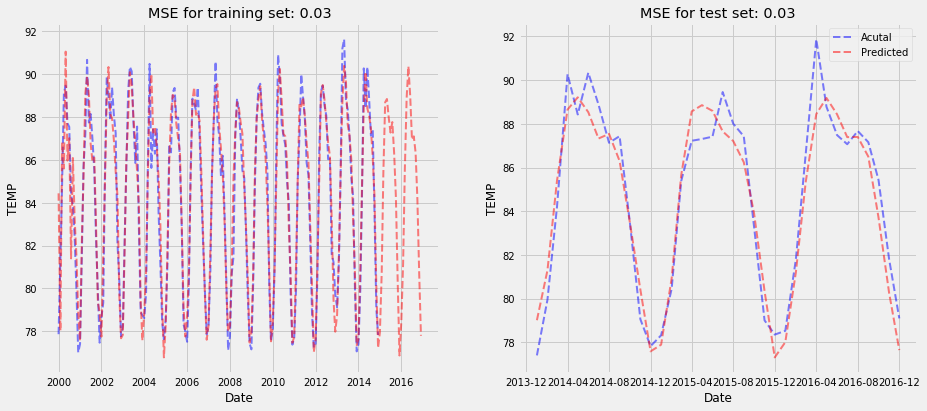

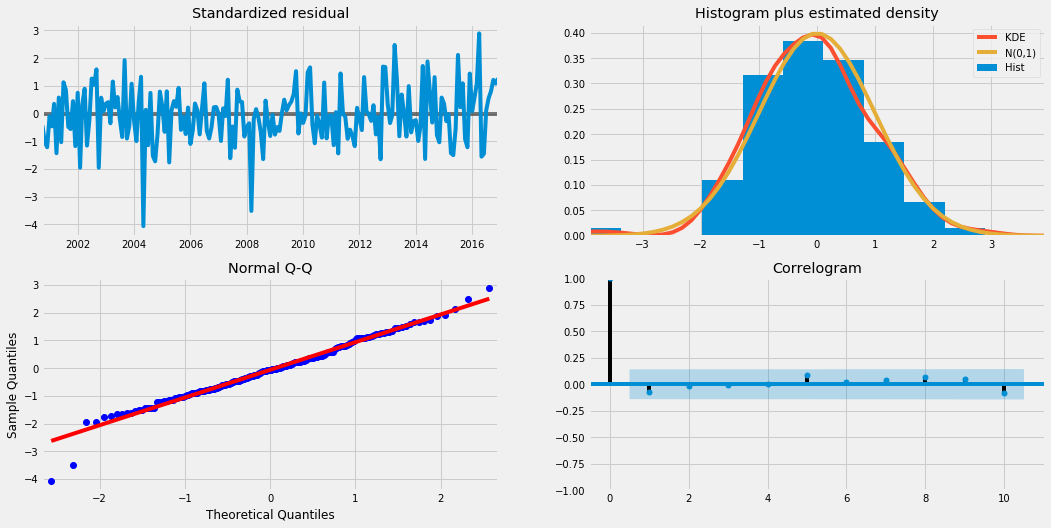

In [49]:
sarima_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

# One-step ahead Forecast, 95% confidence

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


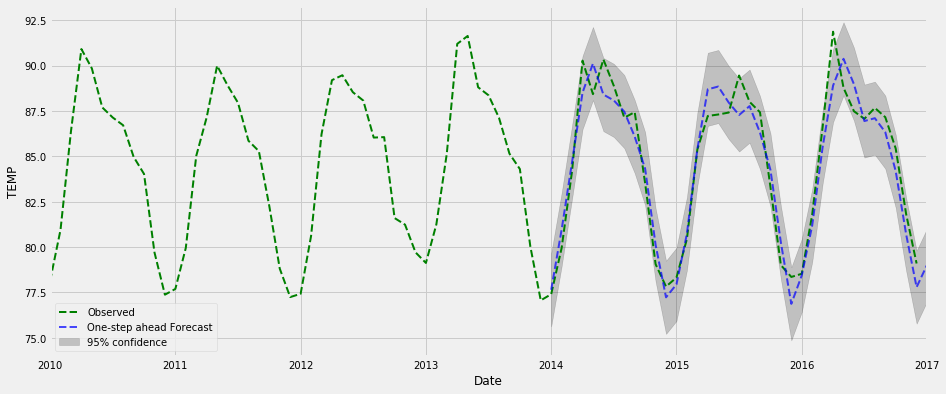

In [50]:
pred = sarima_fit.get_prediction(start=pd.to_datetime('2014-01-01'), end= pd.to_datetime('2017-01-01'),dynamic=False)
pred_ci = pred.conf_int()

#plt.figure(figsize=(14, 7))

xm=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series2['normalized']['2010':].values.reshape(-1, 1))], index= series2['normalized']['2010':].index)

ym=pd.DataFrame([i[0] for i in scaler2.inverse_transform(pred.predicted_mean.values.reshape(-1, 1))], index= pred_ci.index)

lower=pd.Series([i[0] for i in scaler2.inverse_transform(pred_ci['lower normalized'].values.reshape(-1, 1))], index= pred_ci.index)
upper=pd.Series([i[0] for i in scaler2.inverse_transform(pred_ci['upper normalized'].values.reshape(-1, 1))], index= pred_ci.index)

ax = xm.plot(label='Observed',linestyle='--',linewidth=2, markersize=12, color='g')
ym.plot(ax=ax, label='One-step ahead Forecast',linestyle='--',linewidth=2, markersize=12, 
                         alpha=.7, figsize=(14, 6), color='b')

ax.fill_between(pred_ci.index, lower,  upper, color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('TEMP')
plt.legend(['Observed','One-step ahead Forecast','95% confidence'])
plt.savefig('One-step_ahead_Forecast.pdf',bbox_inches='tight')

plt.show()

# long time Forecast 2023, 95% confidence

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


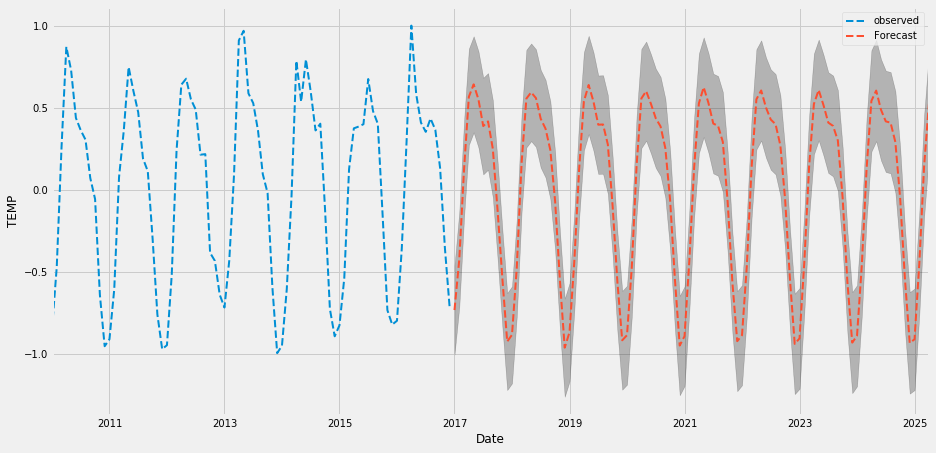

In [51]:
pred_uc = sarima_fit.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = series2['normalized']['2010':].plot(label='observed', figsize=(14, 7),linestyle='--',linewidth=2, markersize=12)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',linestyle='--',linewidth=2, markersize=12)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('TEMP')

plt.legend()
plt.show()

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 864x432 with 0 Axes>

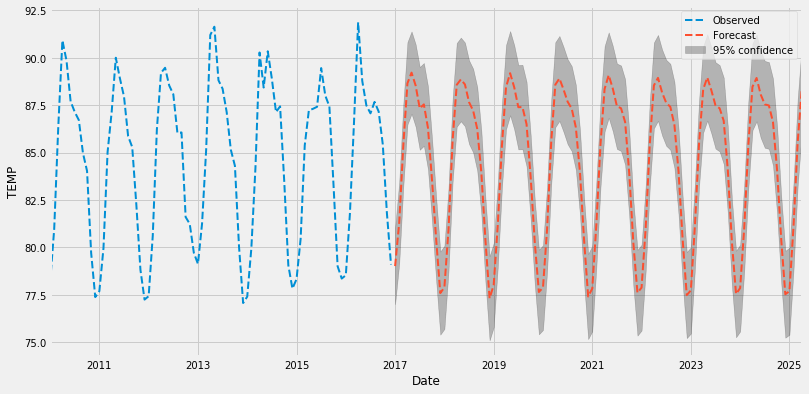

In [52]:
from matplotlib.backends.backend_pdf import PdfPages
pred_uc = sarima_fit.get_forecast(steps=100)
pred_ci = pred_uc.conf_int(alpha=0.05)

#plt.figure(figsize=(14, 7))

xm=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series2['normalized']['2010':].values.reshape(-1, 1))], index= series2['normalized']['2010':].index)

ym=pd.DataFrame([i[0] for i in scaler2.inverse_transform(pred_uc.predicted_mean.values.reshape(-1, 1))], index= pred_ci.index)

lower=pd.Series([i[0] for i in scaler2.inverse_transform(pred_ci['lower normalized'].values.reshape(-1, 1))], index= pred_ci.index)
upper=pd.Series([i[0] for i in scaler2.inverse_transform(pred_ci['upper normalized'].values.reshape(-1, 1))], index= pred_ci.index)




with PdfPages('Forecast.pdf') as pdf:
    plt.figure(figsize=(12, 6))
    ax = xm.plot(label='observed', figsize=(12, 6),linestyle='--',linewidth=2, markersize=12)
    ym.plot(ax=ax, label='Forecast',linestyle='--',linewidth=2, markersize=12)
    ax.fill_between(pred_ci.index, lower, upper,  label='95% confidence', color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('TEMP')
    plt.legend(['Observed','Forecast','95% confidence'])
    #plt.title('Forecast')
    plt.savefig('Forecast1.pdf',bbox_inches='tight')
    #pdf.savefig(plt,bbox_inches='tight')  # saves the current figure into a pdf page
    plt.show()
    plt.close()

#  2- Serial GA-SARIMA

In [53]:
# import relevant module
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import statsmodels.api as sm

%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error

#preprocess
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

from pandas import Series
plt.style.use('fivethirtyeight')
print ("libraries loaded")

libraries loaded


# brute force
-- PARALLEL To select the best models based on AIC

In [54]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import time
from datetime import timedelta

start_time = time.time()

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
	# define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
    model_fit = model.fit(disp=False)
	# make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    
    return yhat[0], model_fit.aic

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat, aic = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error, aic

# one-step sarima forecast
def sarima_forecasting(history, config):
	order, sorder = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	#yhat = model_fit.predict(len(history), len(history))
    
	return model_fit

# walk-forward validation for univariate data
def test_validation(data, n_test, cfg):
	# step over each time-step in the test set
    model_fit = sarima_forecasting(data, cfg)
    pred = model_fit.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
    y_forecasted = pred.predicted_mean
    #print ("type(y_forecasted):", type(y_forecasted))
    y_truth = data['2000-01-01':]

    # Compute the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()
    error2 = np.sqrt(mean_squared_error(y_forecasted , y_truth))

    #print('Test RMSE: %.3f' % error2)
    #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model_fit.aic))
    #print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
	# estimate prediction error
    #error = measure_rmse(test, predictions)
    return mse, error2, model_fit.aic

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result, aic = walk_forward_validation(data, n_test, cfg)
  else:
		# one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        #result, aic = walk_forward_validation(data, n_test, cfg)
        mse, result, aic = test_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] mse=%.4f rmse= %.4f aic= %.3f'  % (key, mse, result, aic))
    #file.write('> Model[%s] mse=%.4f rmse= %.4f aic= %.3f'  % (key, mse, result, aic))
  return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
  models = list()
  p_params = range(0, 1)#[0, 1, 2]
  d_params = [ 0, 1]
  q_params = range(0, 1)#[0, 1, 2]
  P_params = range(0, 1)#[0, 1, 2]
  D_params = [0, 1]
  Q_params = range(0, 1)#[0, 1, 2]
  m_params = seasonal
  for p in p_params:
    for d in d_params:
      for q in q_params:
        for P in P_params:
          for D in D_params:
            for Q in Q_params:
              for m in m_params:
                cfg = [(p,d,q), (P,D,Q,m)]
                models.append(cfg)
  return models

if __name__ == '__main__':
  data = series2['normalized']
  print(data.shape)
  n_test = 2*365
  cfg_list = sarima_configs(seasonal=[12])
  scores = grid_search(data, cfg_list, n_test)
  elapsed_time_secs = time.time() - start_time
  msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
  print(msg) 
  print('done')
  for cfg, error in scores[:3]:
    print(cfg, error)

(204,)
 > Model[[(0, 0, 0), (0, 0, 0, 12)]] mse=0.3260 rmse= 0.5709 aic= 349.125
 > Model[[(0, 0, 0), (0, 1, 0, 12)]] mse=0.0591 rmse= 0.2432 aic= -52.438
 > Model[[(0, 1, 0), (0, 1, 0, 12)]] mse=0.0790 rmse= 0.2810 aic= 39.939
 > Model[[(0, 1, 0), (0, 0, 0, 12)]] mse=0.1354 rmse= 0.3680 aic= 165.915
Execution took: 0:00:00 secs (Wall clock time)
done
[(0, 0, 0), (0, 1, 0, 12)] 0.24317300629407682
[(0, 1, 0), (0, 1, 0, 12)] 0.2810280758172529
[(0, 1, 0), (0, 0, 0, 12)] 0.3680023414060563


#  Accuracy metrics
- The range of (p,d,q,P,D,Q) is selected based on the previous step

In [55]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
  models = list()
  p_params = [0, 1, 6, 9]#range(8, 12)
  d_params = [0]
  q_params = [0, 1, 2, 7, 8, 9 ]#range(0, 10)
  P_params = [0, 1, 2]#range(0, 10)
  D_params = [0, 1]
  Q_params = [0, 1, 2, 7, 8, 9]#range(0, 10)
  m_params = seasonal
  for p in p_params:
    for d in d_params:
      for q in q_params:
        for P in P_params:
          for D in D_params:
            for Q in Q_params:
              for m in m_params:
                cfg = [(p,d,q), (P,D,Q,m)]
                models.append(cfg)
  return models

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    mse = ((forecast - actual) ** 2).mean()
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'mse':mse, 'rmse':rmse, #'acf1':acf1,'corr':corr, 'minmax':minmax})
    return mape, me, mae, mpe, mse, rmse, corr, minmax

# train test split for daily PM2.5 data
series_daily_train = series2['normalized'].loc['2000':'2014']
series_daily_test  = series2['normalized'].loc['2014':]
print(len(series_daily_train),len(series_daily_test))

180 36


# To select the best models based on P-VALUES

    - score_table: contains all best models based ( AIC, MAPE, RMSE)
    - score_table2 : contains all best models FROM score_table based ( P-VALUES < 0.05)


In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
def check(list1, val): 
      
    # traverse in the list 
    for x in list1: 
  
        # compare with all the values 
        # with val 
        if val<= x: 
            return False 
    return True
  
score_table = pd.DataFrame(index=range(0,15),columns= ['(p,d,q)', '(P,D,Q)','AIC','mape',
                                                        'me', 'mae', 'mpe', 'mse', 'rmse', 'corr', 'minmax'])
score_table2=pd.DataFrame(index=range(0,15),columns= ['(p,d,q)', '(P,D,Q)','AIC','mape',
                                                        'me', 'mae', 'mpe', 'mse', 'rmse', 'corr', 'minmax'])
# score a model, return None on failure
def score_model(data,series_daily_test,cfg_list, score_table,score_table2, debug=True):
  k=0
  j2=0
  total=0
  for cfg in cfg_list:
    order, sorder = cfg
    #print(order,sorder)
    try:
      with catch_warnings():
        filterwarnings("ignore")
        sarima = SARIMAX(data, order=order, seasonal_order=sorder,enforce_stationarity=False,enforce_invertibility=False)
        sarima_fit = sarima.fit()
        #print(sarima_fit.summary());
        prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
        prediction.index = series_daily_test.index
        mape, me, mae, mpe, mse, rmse, corr, minmax=forecast_accuracy(prediction, series_daily_test)
        score_table.loc[k]=order, sorder,sarima_fit.aic, mape, me, mae, mpe, mse, rmse, corr, minmax
        for k2 in sarima_fit.pvalues.index:
          if  k2 is not ['sigma2', 'const']:
            if check(sarima_fit.pvalues.values, 0.05):
              score_table2.loc[j2]=order, sorder,sarima_fit.aic, mape, me, mae, mpe, mse, rmse, corr, minmax
              #print(j2)
              j2=j2+1
        k=k+1
    except:
      #print(order,sorder)
      total=total+1
      #continue
  print(total,k, total+k)
  return score_table, score_table2

# model configs
cfg_list=sarima_configs(seasonal=[12])
# grid search
score_table1,score_table2 = score_model(series2['normalized'], series_daily_test, cfg_list, score_table,score_table2)
print('done')
# list top 3 configs
#for cfg, error in scores[:3]:
  #print(cfg, error) 

0 864 864
done


In [57]:
score_table.to_csv('SARIMA_AIC_MAPE_RMSE.csv', sep=',', encoding='utf-8', mode='a', header=True)
score_table2.to_csv('SARIMA_AIC_MAPE_RMSE_P_values.csv', sep=',', encoding='utf-8', mode='a', header=True)

In [58]:
score_table.sort_values(['AIC','rmse'], ascending=[1,1]).head(4)

,"(p,d,q)","(P,D,Q)",AIC,mape,me,mae,mpe,mse,rmse,corr,minmax
792,"(9, 0, 8)","(0, 0, 0, 12)",-164.876,0.444529,-0.0295986,0.143071,-0.21997,0.0281478,0.167773,0.957295,0.122894
540,"(6, 0, 7)","(0, 0, 0, 12)",-160.046,0.463257,-0.034108,0.140457,-0.216192,0.0268177,0.163761,0.959942,0.0968388
229,"(1, 0, 0)","(1, 0, 1, 12)",-159.497,0.466809,-0.0494717,0.142398,-0.206366,0.0281191,0.167688,0.959793,0.193557
828,"(9, 0, 9)","(0, 0, 0, 12)",-158.925,0.462261,-0.0319526,0.145104,-0.227347,0.0275848,0.166087,0.958335,0.122391


In [59]:
score_table2.drop_duplicates(inplace=True)
score_table2.sort_values([ 'AIC','rmse'], ascending=[1,1])

,"(p,d,q)","(P,D,Q)",AIC,mape,me,mae,mpe,mse,rmse,corr,minmax
9,"(0, 0, 0)","(1, 0, 1, 12)",-148.177,0.458842,-0.0495432,0.139759,-0.200593,0.0272963,0.165216,0.961095,0.195071
34,"(0, 0, 1)","(2, 1, 0, 12)",-110.892,0.367977,0.0122085,0.0945813,-0.182121,0.0142993,0.11958,0.978752,-0.263296
90,"(1, 0, 0)","(2, 1, 0, 12)",-110.456,0.375643,0.0134213,0.096992,-0.186618,0.0150715,0.122766,0.977709,-0.465028
17,"(0, 0, 0)","(2, 1, 0, 12)",-107.233,0.348173,0.0101313,0.0890584,-0.170927,0.0126278,0.112373,0.981129,-0.0930694
86,"(1, 0, 0)","(2, 0, 0, 12)",-106.876,0.505323,0.021474,0.141336,-0.340158,0.0304854,0.174601,0.961597,0.0647503
83,"(1, 0, 0)","(1, 1, 0, 12)",-105.539,0.501396,0.0276398,0.124959,-0.274646,0.0267471,0.163545,0.960897,0.0573051
31,"(0, 0, 1)","(1, 1, 0, 12)",-103.871,0.497718,0.0263137,0.122728,-0.272458,0.0262014,0.161868,0.961415,0.0257099
14,"(0, 0, 0)","(2, 0, 0, 12)",-94.7942,0.500317,0.022828,0.133179,-0.32565,0.0282503,0.168078,0.962458,-0.0394117
12,"(0, 0, 0)","(1, 1, 0, 12)",-93.9868,0.49843,0.0266298,0.121779,-0.274724,0.0259172,0.160988,0.961784,-0.0399215
80,"(1, 0, 0)","(1, 0, 0, 12)",-64.889,0.665545,0.0569289,0.19047,-0.523512,0.0508837,0.225574,0.942616,0.116771


# 3- Statespace Model Results for the best models

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# use p=1, d=0, q=1 and P=0, D=1, Q=0, s=365 for constructing the Seasonal ARIMA model based on all the above analysis
sarima = SARIMAX(series2['normalized'], order=(9, 0, 8), seasonal_order=(0, 0, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
sarima_fit = sarima.fit()
print(sarima_fit.summary());

#sarima_fit.plot_diagnostics(figsize=(16,10));
#prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
#prediction.index = series_daily_test.index

pred = sarima_fit.get_prediction(start = 180, end = 290, dynamic=False)
pred_ci = pred.conf_int(alpha=0.05)
pred_ci

#prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
prediction.index = series_daily_test.index
# compare the first 15 predicted values
lower=[round(i[0],4) for i in scaler2.inverse_transform(pred_ci['lower normalized'].values.reshape(-1, 1))[0:24]]
upper=[round(i[0],4) for i in scaler2.inverse_transform(pred_ci['upper normalized'].values.reshape(-1, 1))[0:24]]

test2=[round(i[0],4) for i in scaler2.inverse_transform(series_daily_test.values.reshape(-1, 1))[12:]]
pred2=[round(i[0],4) for i in scaler2.inverse_transform(pred.predicted_mean.values.reshape(-1, 1))[0:24]]

comparison2 = pd.DataFrame({'actual':test2,'predict':pred2,'lower': lower,'upper':upper},index= series_daily_test[12:].index)


mape, me, mae, mpe, mse, rmse, corr, minmax=forecast_accuracy(prediction, series_daily_test)
comparison2.head(15)

                               SARIMAX Results                                
Dep. Variable:             normalized   No. Observations:                  204
Model:               SARIMAX(9, 0, 8)   Log Likelihood                 100.438
Date:                Wed, 12 Feb 2020   AIC                           -164.876
Time:                        02:39:39   BIC                           -105.962
Sample:                    01-01-2000   HQIC                          -141.022
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9751      0.093     10.461      0.000       0.792       1.158
ar.L2         -0.8242      0.091     -9.013      0.000      -1.003      -0.645
ar.L3          0.2745      0.103      2.668      0.0

/home/gad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,actual,predict,lower,upper
YEARMODA,,,,
2015-01-01,78.3226,77.9480,75.9323,79.9636
2015-02-01,80.4500,80.7353,78.7203,82.7502
2015-03-01,85.3774,85.4011,83.3861,87.4160
2015-04-01,87.2267,88.6948,86.6799,90.7097
2015-05-01,87.3065,88.8477,86.8329,90.8625
2015-06-01,87.4133,87.9687,85.9539,89.9835
2015-07-01,89.4548,87.2809,85.2666,89.2953
2015-08-01,88.0065,87.7695,85.7553,89.7837
2015-09-01,87.4300,86.3091,84.2953,88.3229


# Train Test ploting

/home/gad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


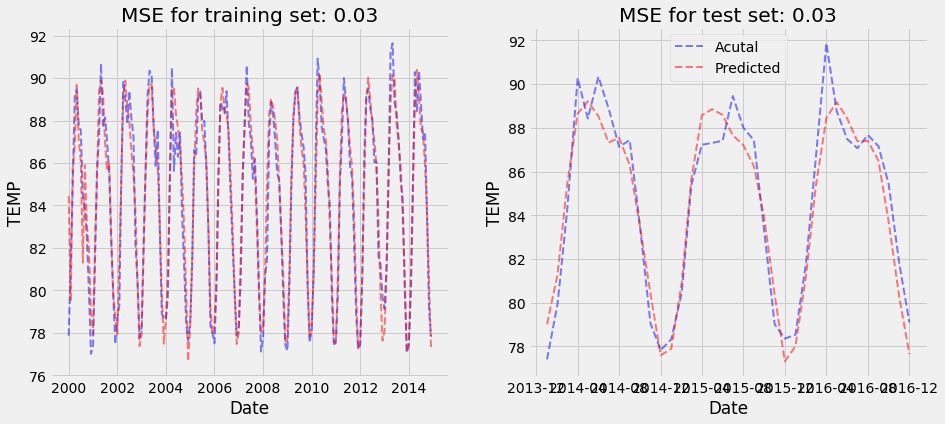

In [61]:
sarima = SARIMAX(series_daily_train, order=(9, 0, 8), seasonal_order=(0, 0, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
sarima_fit = sarima.fit()

series_daily_train1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series_daily_train.values.reshape(-1, 1))], 
                                 index= series_daily_train.index)

fittedvalues1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(sarima_fit.fittedvalues.values.reshape(-1, 1))], 
                           index= sarima_fit.fittedvalues.index)

series_daily_test1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series_daily_test.values.reshape(-1, 1))],
                               index= series_daily_test.index)

prediction1=pd.DataFrame([i[0] for i in scaler2.inverse_transform(prediction.values.reshape(-1, 1))], 
                index= prediction.index)

# plot the results for comparison
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121) # plot the training set
ax1.plot(series_daily_train1, color='blue',linestyle='--',linewidth=2, markersize=12, alpha=0.5);
ax1.plot(fittedvalues1, color='red',linestyle='--',linewidth=2, markersize=12,alpha=0.5);
ax1.set_title('MSE for training set: {:.2f}'.format(mean_squared_error(series_daily_train, sarima_fit.fittedvalues)));
ax1.set_xlabel('Date')
ax1.set_ylabel('TEMP')

ax2 = fig.add_subplot(122) # plot the test set
ax2.plot(series_daily_test1, color='blue',linestyle='--',linewidth=2, markersize=12,alpha=0.5);
ax2.plot(prediction1, color='red',linestyle='--',linewidth=2, markersize=12,alpha=0.5);
ax2.set_title('MSE for test set: {:.2f}'.format(mean_squared_error(series_daily_test, prediction)));
ax2.set_xlabel('Date')
ax2.set_ylabel('TEMP')
plt.legend(['Acutal','Predicted'])

fig.savefig('Train_Test.pdf',bbox_inches='tight')

# One-step ahead Forecast

               actual    predict
YEARMODA                        
2014-01-01  77.403226  77.715548
2014-02-01  79.950000  80.120630
2014-03-01  84.196774  85.336561
2014-04-01  90.276667  89.061267
2014-05-01  88.429032  89.775386
2014-06-01  90.340000  89.374264
2014-07-01  88.883871  87.981574
2014-08-01  87.132258  87.140465
2014-09-01  87.436667  85.560178
2014-10-01  83.512903  83.752753
2014-11-01  79.060000  80.437265
2014-12-01  77.825806  77.157187
2015-01-01  78.322581  77.444823
2015-02-01  80.450000  80.446946
2015-03-01  85.377419  85.187850


/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


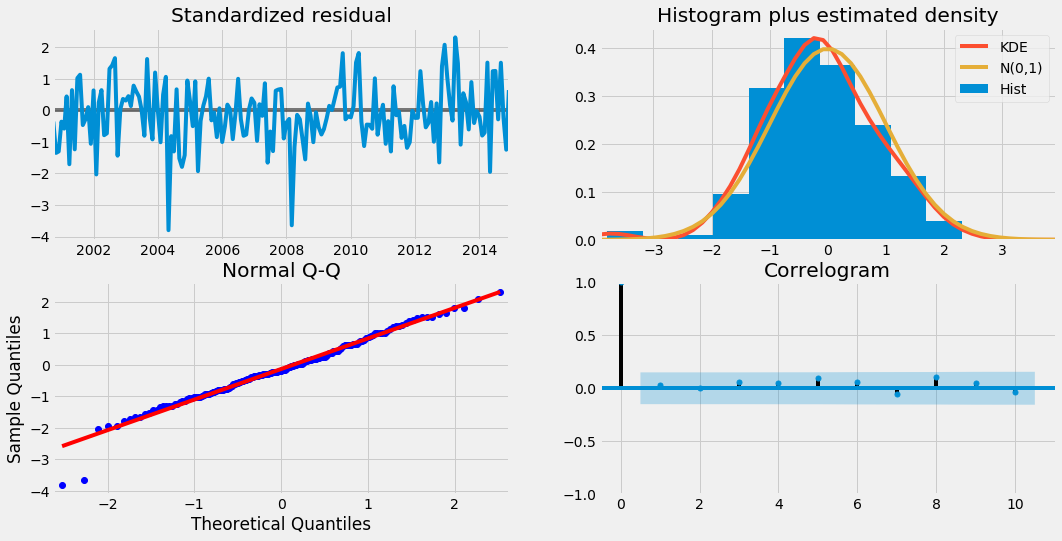

/home/gad/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


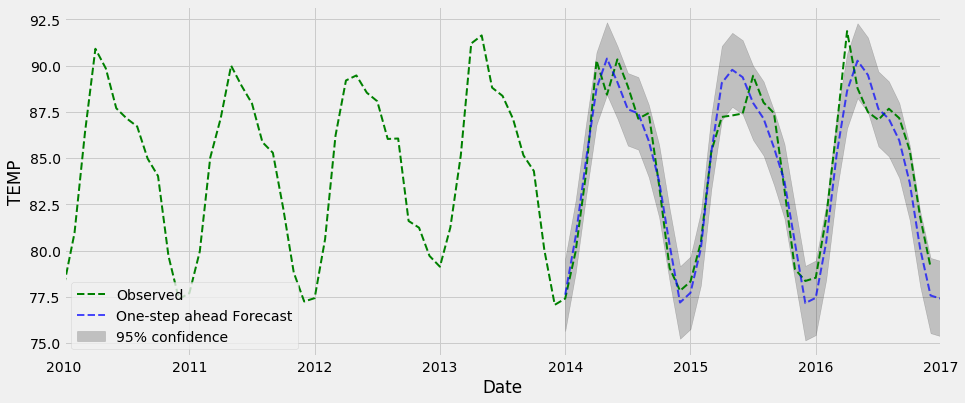

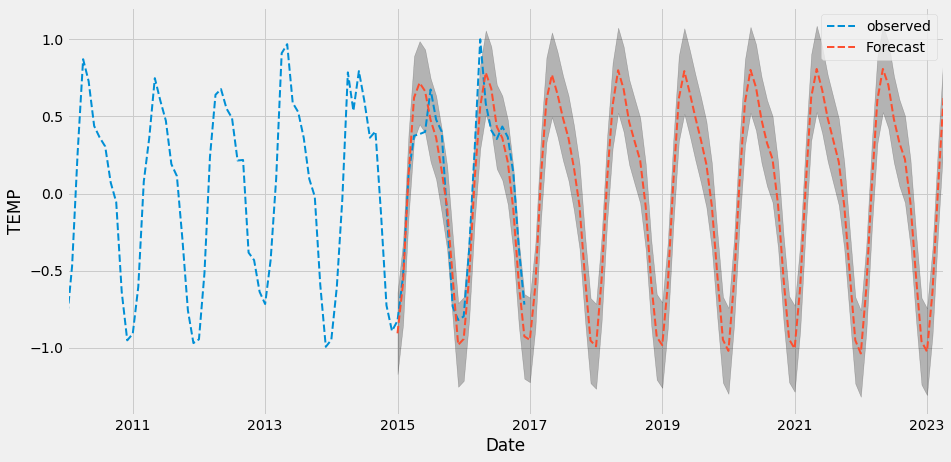

In [62]:
#preds, stderr, ci = sarima_fit.forecast(steps=len(series_daily_test))
#sarima_fit.plot_diagnostics(figsize=(16,10));
prediction = pd.Series(sarima_fit.forecast(steps=len(series_daily_test)))
prediction.index = series_daily_test.index
# compare the first 15 predicted values
test2=[i[0] for i in scaler2.inverse_transform(series_daily_test.values.reshape(-1, 1))]
pred2=[i[0] for i in scaler2.inverse_transform(prediction.values.reshape(-1, 1))]

comparison = pd.DataFrame({'actual':test2,'predict':pred2}, index= series_daily_test.index)
print(comparison.head(15))
sarima_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = sarima_fit.get_prediction(start=pd.to_datetime('2014-01-01'), end= pd.to_datetime('2017-01-01'),dynamic=False)
pred_ci = pred.conf_int()

#plt.figure(figsize=(14, 7))

xm=pd.DataFrame([i[0] for i in scaler2.inverse_transform(series2['normalized']['2010':].values.reshape(-1, 1))], index= series2['normalized']['2010':].index)

ym=pd.DataFrame([i[0] for i in scaler2.inverse_transform(pred.predicted_mean.values.reshape(-1, 1))], index= pred_ci.index)

lower=pd.Series([i[0] for i in scaler2.inverse_transform(pred_ci['lower normalized'].values.reshape(-1, 1))], index= pred_ci.index)
upper=pd.Series([i[0] for i in scaler2.inverse_transform(pred_ci['upper normalized'].values.reshape(-1, 1))], index= pred_ci.index)

ax = xm.plot(label='Observed',linestyle='--',linewidth=2, markersize=12, color='g')
ym.plot(ax=ax, label='One-step ahead Forecast',linestyle='--',linewidth=2, markersize=12, 
                         alpha=.7, figsize=(14, 6), color='b')

ax.fill_between(pred_ci.index, lower,  upper, color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('TEMP')
plt.legend(['Observed','One-step ahead Forecast','95% confidence'])
plt.savefig('One-step_ahead_Forecast.pdf',bbox_inches='tight')

plt.show()

pred_uc = sarima_fit.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = series2['normalized']['2010':].plot(label='observed', figsize=(14, 7),linestyle='--',linewidth=2, markersize=12)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',linestyle='--',linewidth=2, markersize=12)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('TEMP')

plt.legend()
plt.show()